In [5]:
import numpy as np 
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt
from bisect import bisect_left
import random
from cdlib import algorithms
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from node2vec import Node2Vec
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import coverage_error
# from networkx.algorithms.community.quality import modularity, conductance

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from torch_geometric.datasets import Planetoid

torch.cuda.is_available()

alpha_unicode = r"\u03B1"
alpha_character = alpha_unicode.encode('utf-8').decode('unicode_escape')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer', 'leidenalg', 'infomap', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'infomap'}


## Task 0 - Create Graphs

### Extract data from the txt files


In [6]:
path = "Cit-HepPh.txt"
path2 = "cit-HepPh-dates.txt"
data = []
with open(path, "r") as file:
    for line in file:
        values = line.strip().split()
        values[0]=int(values[0])
        values[1]=int(values[1])
        data.append(values)

data = sorted(data, key=lambda x: (x[0], x[1]))
print(len(data))
print(data[0:100])
# data is sorted

# ERROR->
check_array = np.zeros(len(data))
###########

date_published = {}
with open(path2, "r") as file:
    for line in file:
        values = line.strip().split()
        values[0]=int(values[0])
        date_published[values[0]]=values[1]

date_published = dict(sorted(date_published.items(), key=lambda item: (item[1][0:4], item[1][5:7], item[1][8:10])))
# date_published = dict(sorted(date_published.items(), key=lambda item: item[0]))
        
print(date_published)
print(len(date_published))
# date_published dictionary is sorted on the basis of the dates the papers are published


421578
[[1001, 9212308], [1001, 9305239], [1001, 9306240], [1001, 9312276], [1001, 9312333], [1001, 9401294], [1001, 9403226], [1001, 9409265], [1001, 9511336], [1001, 9601359], [1001, 9602280], [1001, 9610553], [1001, 9701390], [1001, 9702424], [1001, 9708239], [1001, 9709423], [1001, 9710255], [1001, 9802439], [1001, 9810389], [1001, 9810409], [1001, 9903515], [1001, 9903516], [1001, 9905323], [1001, 9907385], [1001, 9907523], [1001, 9908523], [1001, 9909506], [1001, 9910563], [1001, 9912251], [1002, 9303309], [1002, 9307201], [1002, 9401219], [1002, 9407389], [1002, 9409375], [1002, 9503443], [1002, 9504316], [1002, 9508343], [1002, 9606211], [1002, 9606386], [1002, 9609331], [1002, 9803277], [1002, 9807423], [1002, 9808299], [1002, 9808312], [1002, 9811308], [1002, 9812320], [1002, 9812472], [1002, 9902371], [1002, 9902443], [1002, 9903404], [1002, 9907422], [1002, 9909540], [1002, 9912236], [1002, 9912463], [1002, 9912516], [1003, 9311243], [1003, 9405410], [1003, 9503208], [1003,

### Creating graphs from extracted data
- We create an array of graphs in which the i<sup>th</sup> graph holds all the data about the citation network from 1992 till the year **1992 + i**
- This helps us analyze how the graph is changing over the years
  
**Method**  
We add papers as nodes to the graph on the basis of the date they were published.  
After adding a paper to the network, we draw all those edges which originate from that node to other nodes (the papers the current paper has cited)

In [7]:
# Create graph year by year
G = nx.DiGraph()

G_array = []
iterator = iter(date_published.items())

# def fn(arr):
#     for ele in arr:
#         print(ele.number_of_nodes(), end=" ")
#     print()
#     for ele in arr:
#         print(ele.number_of_edges(), end=" ")
#     print()

prev_year_and_month = "-1"
curr_year_and_month = "1992-02"
x_time = []

for node, date in iterator:
    # adds a graph instance to the graph array
    curr_year_and_month = date[0:7]
    if curr_year_and_month !=prev_year_and_month:
        if prev_year_and_month!="-1":
            x_time.append(curr_year_and_month)
            print(f"Current year and month = {curr_year_and_month}")
            print(f"previous year and month = {prev_year_and_month}")
            print(f"number of nodes in G = {G.number_of_nodes()}")
            print(f"Number of edges in G = {G.number_of_edges()}")
            G_array.append(G.copy())
            print(f"size of G_array = {len(G_array)}")
            print()
    prev_year_and_month = curr_year_and_month

    # creates the next graph instance
    G.add_node(node)
    ind = bisect_left(data, [node, float('-inf')])
    for i in range(ind, len(data)):
        if data[i][0] != node:
            break
        G.add_edges_from([data[i]])
        check_array[i]=1

x_time.append(curr_year_and_month)
print(f"Current year and month = {curr_year_and_month}")
print(f"previous year and month = {prev_year_and_month}")
print(f"number of nodes in G = {G.number_of_nodes()}")
print(f"Number of edges in G = {G.number_of_edges()}")
G_array.append(G.copy())
print(f"size of G_array = {len(G_array)}")
print()

Current year and month = 1992-03
previous year and month = 1992-02
number of nodes in G = 2
Number of edges in G = 0
size of G_array = 1

Current year and month = 1992-04
previous year and month = 1992-03
number of nodes in G = 31
Number of edges in G = 3
size of G_array = 2

Current year and month = 1992-05
previous year and month = 1992-04
number of nodes in G = 72
Number of edges in G = 4
size of G_array = 3

Current year and month = 1992-06
previous year and month = 1992-05
number of nodes in G = 125
Number of edges in G = 7
size of G_array = 4

Current year and month = 1992-07
previous year and month = 1992-06
number of nodes in G = 202
Number of edges in G = 12
size of G_array = 5

Current year and month = 1992-08
previous year and month = 1992-07
number of nodes in G = 292
Number of edges in G = 25
size of G_array = 6

Current year and month = 1992-09
previous year and month = 1992-08
number of nodes in G = 364
Number of edges in G = 32
size of G_array = 7

Current year and mont

### Note: Some datapoints have been excluded

In [8]:
count=0
cat1 = set()
cat2 = set()
for i , check_val in enumerate(check_array):
    if check_val == 0:
        cat1.add(data[i][0])
        cat2.add(data[i][1])
        count+=1
print(f"count = {count}")
print(cat1)
print(cat2)
print(len(cat1))
# THE NODES IN THE SET cat1 ARE NOT PRESENT IN THE DATES.TXT FILE
# THEY ARE ONLY PRESENT IN THE EDGES.TXT FILE
# SO, THESE PAPERS ARE NOT BEING ADDED TO OUR GRAPH, AND NEITHER ARE THE EDGES ORIGINATING FROM THESE PAPERS

count = 74164
{301222, 301223, 301224, 301225, 211336, 301226, 301227, 301228, 301229, 301230, 211337, 212314, 301231, 301233, 301234, 301235, 211338, 212315, 301236, 301237, 301238, 301239, 301240, 211339, 212316, 301241, 302122, 301242, 301243, 301244, 301245, 212317, 301246, 301247, 301248, 301249, 301250, 211341, 212318, 301252, 301253, 301254, 301255, 211342, 212319, 301256, 301257, 301258, 301260, 211343, 301261, 205001, 205003, 205004, 205005, 212320, 205007, 205008, 205009, 205010, 205011, 205012, 205013, 205014, 205015, 205016, 205017, 301263, 205019, 205020, 205021, 205022, 205023, 205024, 205025, 205026, 205027, 205028, 205029, 205030, 205031, 205032, 205033, 205034, 205035, 205036, 205037, 205038, 205039, 205040, 205041, 205042, 205043, 205044, 205045, 205046, 205047, 205048, 205049, 205050, 205051, 205052, 205053, 205054, 205055, 205056, 205057, 205058, 205059, 205060, 205061, 205062, 205063, 205064, 205065, 205066, 205067, 205068, 205069, 205070, 205071, 205072, 205073, 2

## Task 1 - Temporal Properties

### Property 1 - Analyzing the number of papers and number of citations

#### Plotting how the number of papers and number of citation change with time

122
122


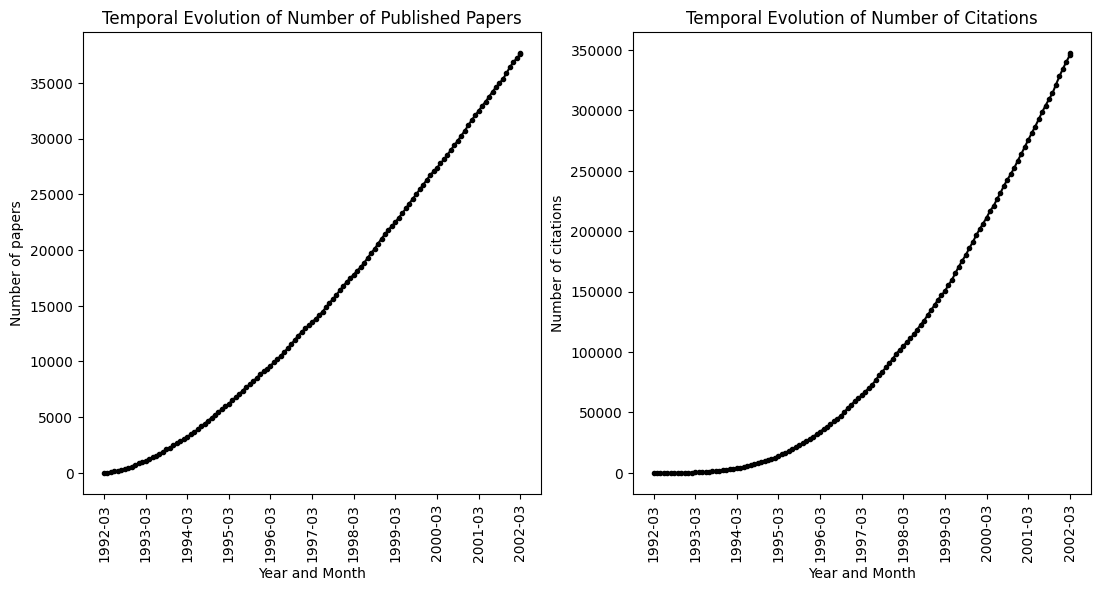

In [11]:
y_nodes = []
y_edges = []

for i, G in  enumerate(G_array):
    # print(f"num nodes = {G.number_of_nodes()}")
    y_nodes.append(G.number_of_nodes())
    y_edges.append(G.number_of_edges())

print(len(x_time))
print(len(y_nodes))

every_12th_time = x_time[::12] # used to get a clear labelling for the x-axis, otherwise the dates overlap
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.plot(x_time, y_nodes, linestyle="-", marker=".", label="number of papers", color="black")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.xlabel("Year and Month")
plt.ylabel("Number of papers")
plt.title("Temporal Evolution of Number of Published Papers")

plt.subplot(122)
plt.plot(x_time, y_edges, marker=".", label="number of citations", color="black")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.xlabel("Year and Month")
plt.ylabel("Number of citations")
plt.title("Temporal Evolution of Number of Citations")
plt.show()

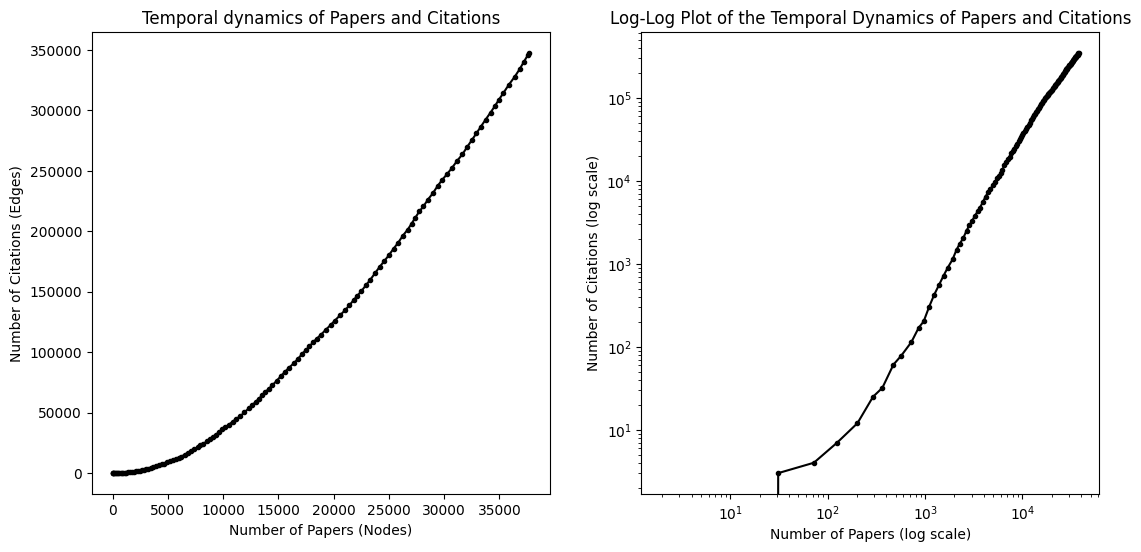

In [12]:
y_arr = []
for i, G in enumerate(G_array):
    y_arr.append(y_edges[i]/float(y_nodes[i]))

plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.plot(y_nodes, y_edges, marker=".", color="black")
plt.xlabel("Number of Papers (Nodes)")
plt.ylabel("Number of Citations (Edges)")
plt.title("Temporal dynamics of Papers and Citations")

plt.subplot(122)
plt.loglog(y_nodes, y_edges, marker=".", color="black")
plt.xlabel('Number of Papers (log scale)')
plt.ylabel('Number of Citations (log scale)')
plt.title('Log-Log Plot of the Temporal Dynamics of Papers and Citations')
plt.show()

# DO SOME THINGS WITH THIS DATA
# CAN TRY OUT POLYNOMIAL REGRESSION ON IT

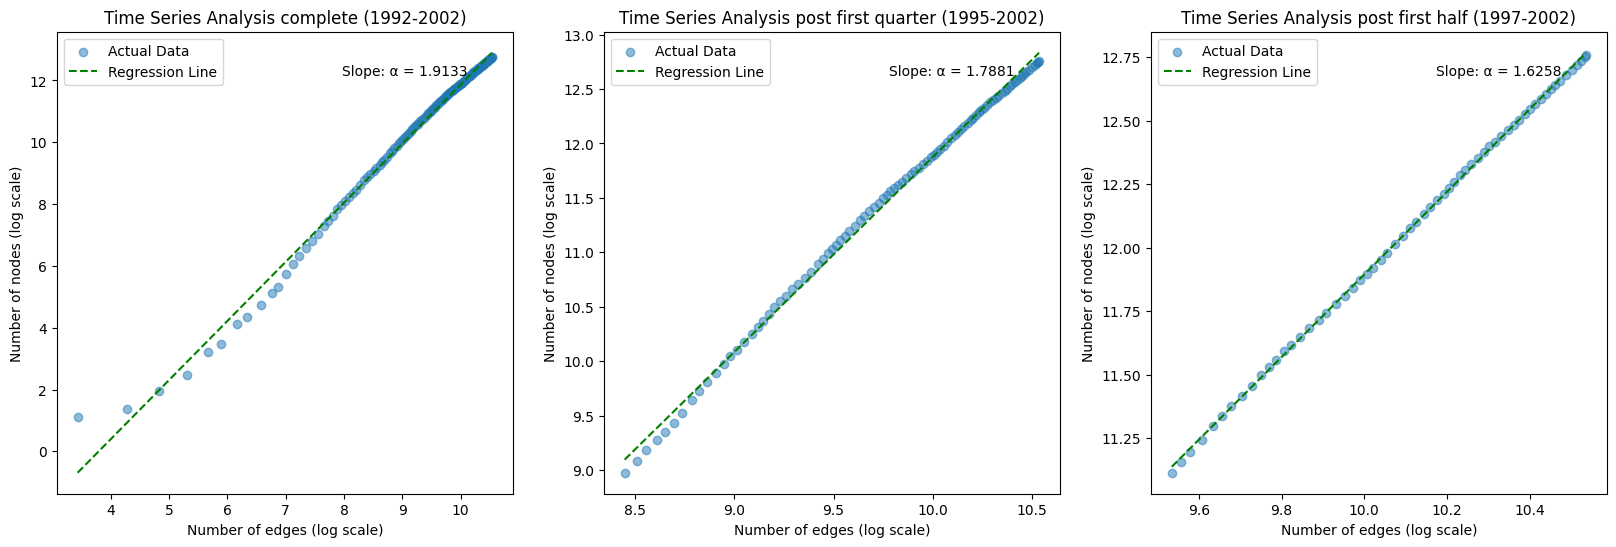

α = 1.7757


In [112]:


def calculate_alpha(y_nodes, y_edges, start_index, plt_title):

    y_nodes = y_nodes[start_index:]
    y_edges = y_edges[start_index:]
    log_y_nodes = np.log(y_nodes)
    log_y_edges = np.log(y_edges)

    X = log_y_nodes.reshape(-1, 1)
    y = log_y_edges
    model = LinearRegression()
    model.fit(X, y)

    slope = model.coef_[0]
    intercept = model.intercept_

    x_values = np.linspace(min(log_y_nodes), max(log_y_nodes), 100)
    y_values = slope * x_values + intercept

    plt.scatter(log_y_nodes, log_y_edges, label='Actual Data', alpha = 0.5)
    plt.plot(x_values, y_values, color='green', linestyle='--', label='Regression Line')
    plt.xlabel("Number of edges (log scale)")
    plt.ylabel("Number of nodes (log scale)")
    plt.title(plt_title)
    plt.text(0.9, 0.9, f'Slope: {alpha_character} = {round(slope, 4)}', ha='right', va='bottom', transform=plt.gca().transAxes)

    plt.legend()
    return slope, intercept

plt.figure(figsize=(20, 6))
plt.subplot(131)
alpha1, _ = calculate_alpha(y_nodes, y_edges, 1, "Time Series Analysis complete (1992-2002)")
plt.subplot(132)
alpha2, _ = calculate_alpha(y_nodes, y_edges, int(len(y_nodes)/4) ,"Time Series Analysis post first quarter (1995-2002)")
plt.subplot(133)
alpha3, _ = calculate_alpha(y_nodes, y_edges, int(len(y_nodes)/2) ,"Time Series Analysis post first half (1997-2002)")
plt.show()


alpha = (alpha1+alpha2+alpha3)/3
print(f"{alpha_character} = {round(alpha, 4)}")


### Property 2 - Plotting the Indegrees and the Outdegrees in the graphs
The plots show the pareto-like fat-tailed distribution. 
In every row, 
1. The first plot shows how a small number of papers are cited a very high number of times, while most of the papers barely get cited.
2. The second plot shows how a small number of papers cited a lot of other papers, while most of the papers did not site many papers.

Some examples of Pareto Distribution are displayed below:

<img src="./images/pareto_distribution.png" alt="Graph Showing Pareto Distribution" width="300px" height="300px">
<img src="./images/pareto_distribution2.png" alt="Graph Showing Pareto Distribution" width="300px" height="300px">

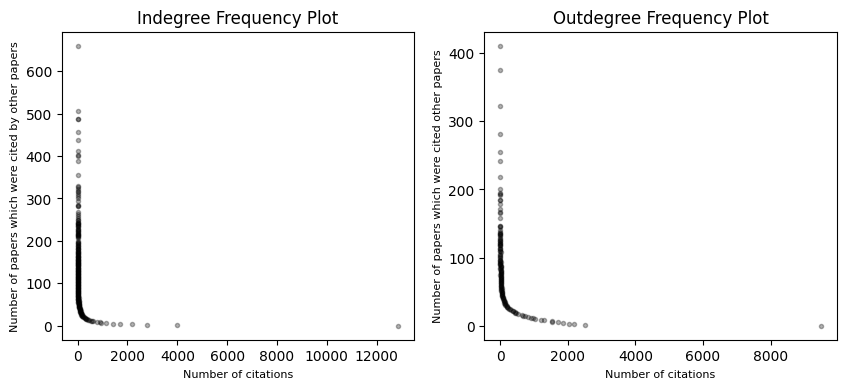

In [8]:
def plot_graph_degrees(G):
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    in_degrees = dict(sorted(in_degrees.items(), key=lambda item: -item[1]))
    out_degrees = dict(sorted(out_degrees.items(), key = lambda item: -item[1]))

    def plot_function(arr, xlabel, ylabel):
        d = {}
        for e in arr:
            if e not in d:
                d[e]=1
            else:
                d[e]+=1
        x = np.array(list(d.values()))
        y = np.array(list(d.keys()))

        # messing around
        # index_of_max = np.argmax(x)
        # x = np.delete(x, index_of_max)
        # y = np.delete(y, index_of_max)
        ####
        
        plt.scatter(x=x,y=y, marker=".", alpha=0.3, color="black")
        xlab = plt.xlabel(xlabel=xlabel)
        xlab.set_fontsize(8)
        ylab = plt.ylabel(ylabel=ylabel)
        ylab.set_fontsize(8)


    in_degrees_values = np.array(list(in_degrees.values()))
    out_degrees_values = np.array(list(out_degrees.values()))

    plt.figure(figsize=(10, 4)) 
    plt.subplot(1, 2, 1) 
    plot_function(in_degrees_values, xlabel="Number of citations", ylabel="Number of papers which were cited by other papers")
    plt.title("Indegree Frequency Plot")

    plt.subplot(1, 2, 2) 
    plot_function(out_degrees_values, xlabel="Number of citations", ylabel="Number of papers which were cited other papers")
    plt.title("Outdegree Frequency Plot")
    plt.show()


plot_graph_degrees(G)

### Property 3 - Density of the Graph

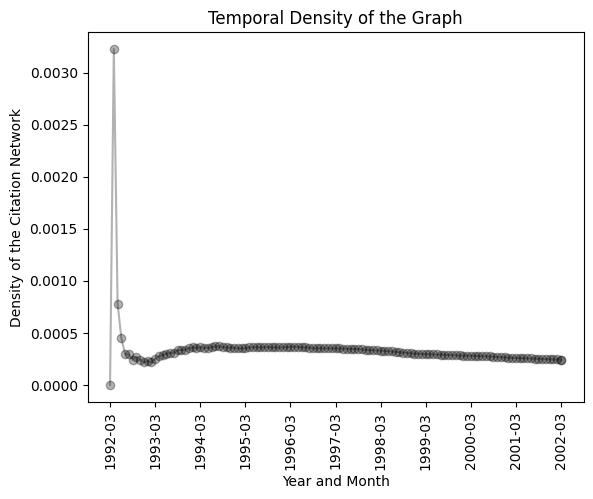

In [9]:
density_array = []
for digraph in G_array:
    density = nx.density(digraph)
    density_array.append(density)

plt.plot(x_time, density_array, marker="o", color="black", alpha = 0.3)
plt.xlabel("Year and Month")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.ylabel("Density of the Citation Network")
plt.title("Temporal Density of the Graph")
plt.show()

### Property 4 - Average Clustering Coefficient

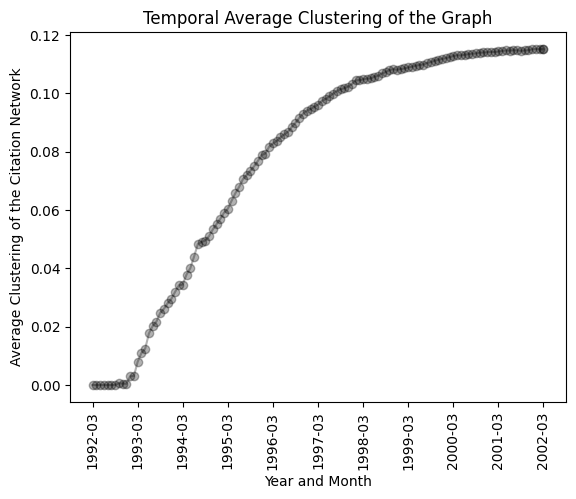

In [10]:
# TAKES 2 MINUTES TO RUN
# TIME COMPLEXITY = O(V*E)
average_clustering_array = []
for i, digraph in enumerate(G_array):
    average_clustering = nx.average_clustering(digraph)
    average_clustering_array.append(average_clustering)
    # print(f"{i}th graph has average clustering of: {average_clustering}")

plt.plot(x_time, average_clustering_array, marker="o", color="black", alpha = 0.3)
plt.xlabel("Year and Month")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.ylabel("Average Clustering of the Citation Network")
plt.title("Temporal Average Clustering of the Graph")
plt.show()

### Property 5 - Identifying Citation Bursts

In [13]:
# Relative Growth of Citations used over Absolute Growth
def identify_citation_bursts(G_array, threshold_percentage):
    bursts = []

    for i in range(1, len(G_array)):
        G_current = G_array[i]
        G_previous = G_array[i - 1]

        # Extracting citation data from the graphs
        edges_current = set(G_current.edges())
        edges_previous = set(G_previous.edges())

        # Find newly added citations
        new_citations = edges_current - edges_previous

        # Count new citations per paper
        citation_counts = pd.Series([target for _, target in new_citations]).value_counts()

        # Calculate the percentage increase in citations for each paper
        total_citations_previous = len(edges_previous)
        citation_percentage_increase = citation_counts / total_citations_previous * 100

        # Identify papers with citation bursts based on percentage increase
        papers_with_bursts = citation_percentage_increase[citation_percentage_increase > threshold_percentage].index.tolist()

        # Add information about the time period to the results
        bursts.extend([(paper, i) for paper in papers_with_bursts])

    return bursts


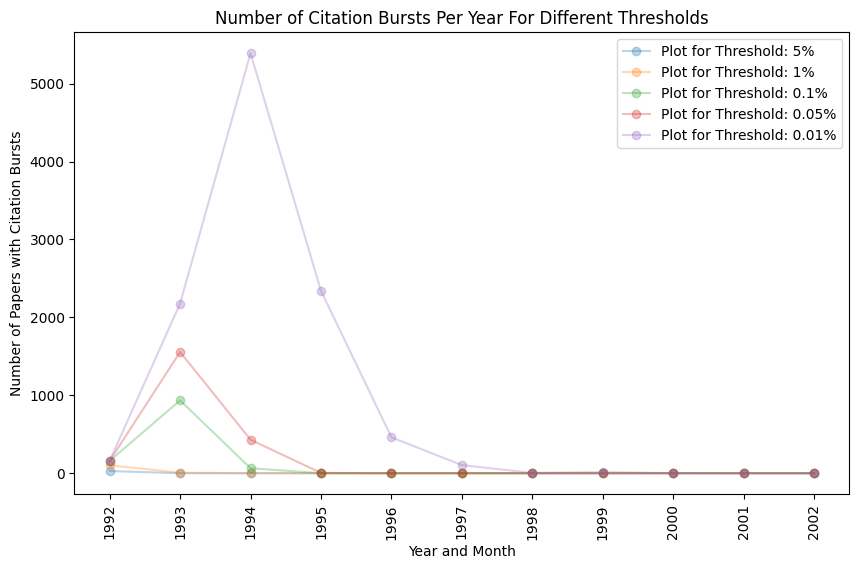

In [12]:
x_years = []
for i in range(1992, 2003):
    x_years.append(i)

def plot_citation_bursts(G_array, threshold_percentage):
    bursts_array = identify_citation_bursts(G_array, threshold_percentage)
    y_bursts = np.zeros(len(x_years))
    for  ele in bursts_array:
        index = int(ele[1]/12)
        y_bursts[index]+=1
    label = f"Plot for Threshold: {threshold_percentage}%"
    plt.plot(x_years, y_bursts, marker="o", alpha=0.3, label=label)



plt.figure(figsize=(10, 6))

plot_citation_bursts(G_array, 5)
plot_citation_bursts(G_array, 1)
plot_citation_bursts(G_array, 0.1)
plot_citation_bursts(G_array, 0.05)
plot_citation_bursts(G_array, 0.01)

plt.xlabel("Year and Month")
plt.ylabel('Number of Papers with Citation Bursts')
plt.title("Number of Citation Bursts Per Year For Different Thresholds")
plt.xticks(x_years, x_years, rotation=90)
plt.legend(loc="upper right")  
plt.show()


### Property 6 - Diameter of the Graph

In [15]:
def find_largest_diameter(graph):
    # Find strongly connected components
    graph.to_undirected()
    connected_components = list(nx.connected_components(graph))
    if not connected_components:
        print("No connected components found.")
        return 0

    # Find the largest connected component
    largest_component_nodes = max(connected_components, key=len)
    largest_component = graph.subgraph(largest_component_nodes)

    # Calculate the diameter of the largest connected component
    diameter = nx.diameter(largest_component)
    return diameter

# The calculation of effective diameter has O(V^3) time complexity
G_array_yearly = G_array[::12]
diameter_array = []
for i, G in enumerate(G_array_yearly):
    diameter = find_largest_diameter(G)
    diameter_array.append(diameter)
    print(f"Graph {i} has effective diameter:", diameter)


Graph 0 has effective diameter: 0
Graph 1 has effective diameter: 0
Graph 2 has effective diameter: 1
Graph 3 has effective diameter: 2
Graph 4 has effective diameter: 2
Graph 5 has effective diameter: 2
Graph 6 has effective diameter: 3
Graph 7 has effective diameter: 9
Graph 8 has effective diameter: 9
Graph 9 has effective diameter: 9
Graph 10 has effective diameter: 11


11


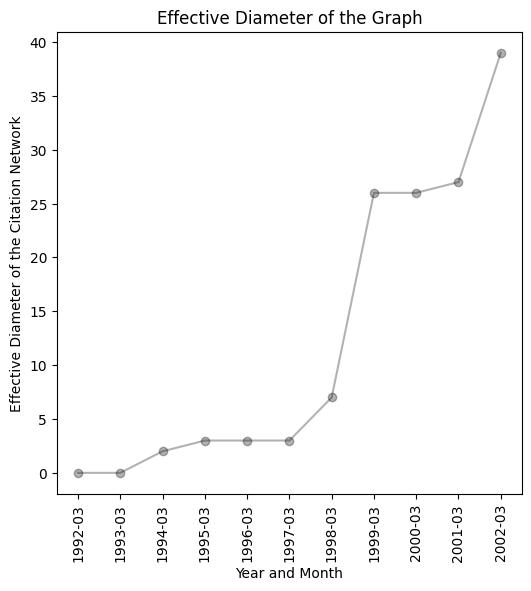

In [13]:
print(len(G_array_yearly))
plt.figure(figsize=(6, 6))

plt.plot(x_time[::12], diameter_array, marker="o", color="black", alpha = 0.3)
plt.xlabel("Year and Month")
# plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.xticks(rotation=90)
plt.ylabel("Effective Diameter of the Citation Network")
plt.title("Effective Diameter of the Graph")

plt.show()



Graph 0:  0
Graph 1:  0
Graph 2:  1
Graph 3:  2
Graph 4:  2
Graph 5:  3
Graph 6:  3
Graph 7:  5
Graph 8:  6
Graph 9:  6
Graph 10:  7
Graph 11:  8
Graph 12:  8
Graph 13:  8
Graph 14:  15
Graph 15:  15
Graph 16:  15
Graph 17:  14
Graph 18:  14
Graph 19:  15
Graph 20:  16


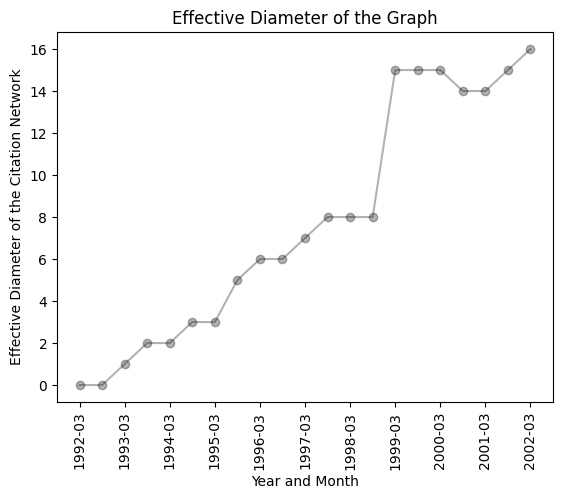

In [38]:
# ALTERNATIVE CODE THAT DOES NOT WORK BECAUSE MORE RAM IS NEEDED
def calculate_effective_diameter(graph, alpha=0.9):
    graph = graph.to_undirected()
    all_shortest_paths = []
    for source in graph.nodes:
        paths = nx.shortest_path_length(graph, source=source)
        all_shortest_paths.extend(paths.values())

    all_shortest_paths.sort()
    index = int(len(all_shortest_paths)*alpha)
    return all_shortest_paths[index]

arr = []
for i, G in enumerate(G_array_yearly):
    effective_diameter = calculate_effective_diameter(G, alpha=0.9)
    print(f"Graph {i}: ", effective_diameter)
    arr.append(effective_diameter)


plt.plot(x_time[::6], arr, marker="o", color="black", alpha = 0.3)
plt.xlabel("Year and Month")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.ylabel("Effective Diameter of the Citation Network")
plt.title("Effective Diameter of the Graph")
plt.show()

## Task 2

### Part 1 - Community Detection Algorithms
- Need to implement 2 algorithms

The following algorithms can be used: 
1. deepwalk
2. node2vec  (bfs + dfs)
3. Graph Convolutional Network


#### Useful functions Used in Every Method

##### Function to Obtain Cluster Labels from Node Embeddings

In [9]:
def find_cluster_labels(node_embeddings, num_clusters = 5):

    # Extract node features for clustering
    X = np.array(list(node_embeddings.values()))

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(X)

    # Assign cluster labels to nodes
    return kmeans.labels_

##### Function to Visualize the Clusters

In [10]:
def plot_community_2d(cluster_labels, node_embeddings, method, num_clusters=5):
    node_cluster_mapping = dict(zip(G.nodes, cluster_labels))

    sampled_nodes = G.nodes()
    # Extract embeddings and labels for sampled nodes
    sampled_embeddings = [node_embeddings[str(node)] for node in sampled_nodes]
    sampled_embeddings = np.array(sampled_embeddings)
    sampled_cluster_labels = [node_cluster_mapping[node] for node in sampled_nodes]

    # Use t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2) #, random_state=42)
    node_embeddings_2d = tsne.fit_transform(sampled_embeddings)

    # Plot the sampled node embeddings with colors based on clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=sampled_cluster_labels, cmap='viridis', alpha=0.3, marker=".")

    # Add a legend
    legend_labels = [f'Cluster {i}' for i in range(num_clusters)]
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters')

    # Annotate points with node labels (optional)
    # for i, node in enumerate(sampled_nodes):
    #     plt.annotate(str(node), (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]))

    plt.title(f't-SNE Visualization of Sampled Node Embeddings with Clusters using {method}')
    plt.show()

#### Method 1 - DeepWalk

##### Create a List of Random Walks to train the model on 

In [12]:
def random_walk(start, length):
    walk = [str(start)]

    for i in range(length):
        neighbours = [node for node in G.neighbors(start)]
        if not neighbours:
            break
        next_node = np.random.choice(neighbours, 1)[0]
        walk.append(str(next_node))
        start = next_node

    return walk

walks = []
for node in G.nodes:
    # 80 random walks of length 10 for every node
    for _ in range(80):
        walks.append(random_walk(node, 10))


##### Train the Deepwalk Model and obtain the Node Embeddings

In [13]:
# TAKES 5 MINUTES TO RUN
model_deepwalk = Word2Vec(walks,
                 hs=1,
                 sg=1,
                 vector_size=100,
                 window=10,
                 workers=1,
                 seed=1)

print(f"shape of embedding matrix: {model_deepwalk.wv.vectors.shape}")

# Retrieve node embeddings
node_embeddings_deepwalk = {str(node): model_deepwalk.wv[str(node)] for node in G.nodes}

shape of embedding matrix: (37686, 100)


##### Perform K-means clustering on the Node Embeddings

In [14]:
num_clusters = 5
cluster_labels_deepwalk = find_cluster_labels(node_embeddings_deepwalk, num_clusters)

# # Print the cluster assignments for each node
# for node, cluster_label in node_cluster_mapping.items():
#     print(f"Node {node} belongs to Cluster {cluster_label}")

##### Visualize the communities

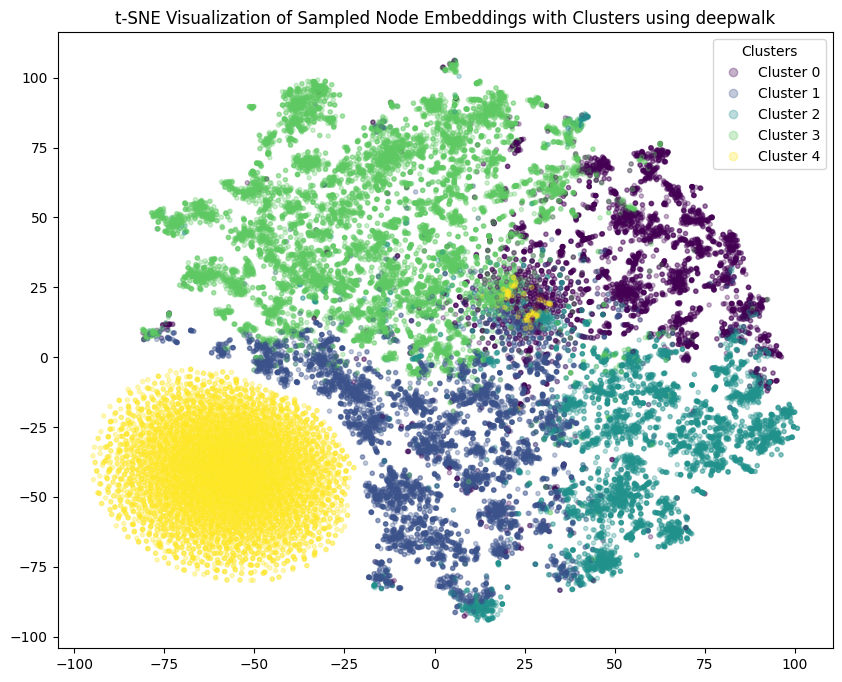

In [15]:
plot_community_2d(cluster_labels_deepwalk, node_embeddings_deepwalk, "deepwalk")

#### Method 2 - Node2Vec

##### Train the Node2Vec model and obtain the Node Embeddings

In [164]:
# TAKES 25 MINUTES
G = G_array[-1]
model_node2vec = Node2Vec(G, dimensions=100, walk_length=10, num_walks=200, workers=1, seed=0, disable=True)
model_node2vec = model_node2vec.fit(window=10, min_count=1, batch_words=4)

# Retrieve node embeddings
node_embeddings_node2vec = {str(node): model_node2vec.wv[str(node)] for node in G.nodes}

Generating walks (CPU: 1): 100%|██████████| 200/200 [01:48<00:00,  1.85it/s]


##### Perform K-means clustering on the Node Embeddings

In [165]:
cluster_labels_node2vec = find_cluster_labels(node_embeddings_node2vec)

##### Visualize the Communities

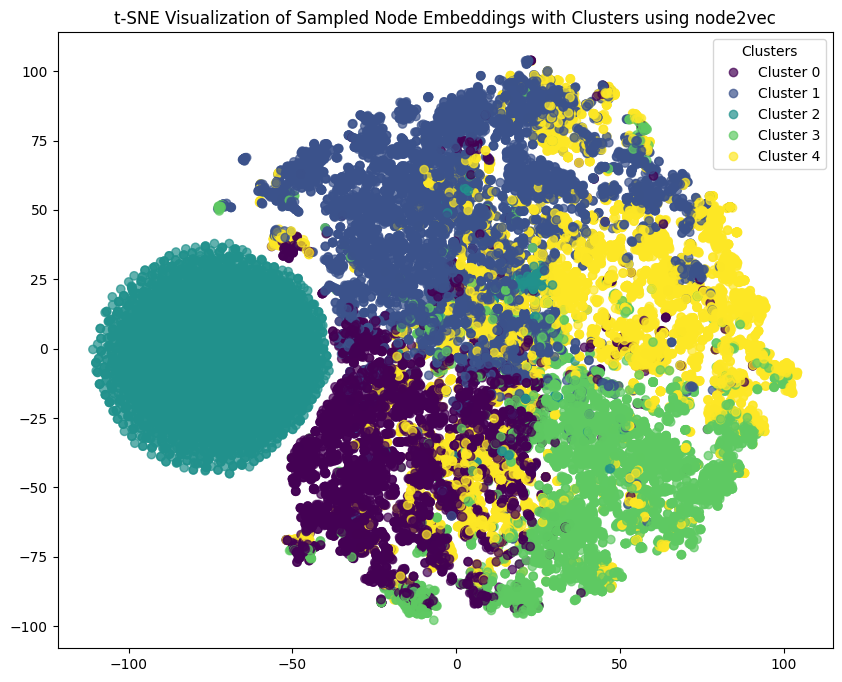

In [167]:
plot_community_2d(cluster_labels_node2vec, node_embeddings_node2vec, "node2vec")

#### Method 3 - Graph Convolutional Network

##### Create the GCN Model

In [11]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

##### Preprocess the Data and Obtain the Node Embeddings

In [19]:
G = G_array[-1]
def preprocess_graph(G):
    # map[node] = index
    node_to_index = {node: index for index, node in enumerate(G.nodes)}
    # print(node_to_index)

    # Convert edges to integer indices and convert to a torch tensor
    edges_index = [(node_to_index[src], node_to_index[dst]) for src, dst in G.edges]
    edge_index = torch.tensor(edges_index, dtype=torch.long).t().contiguous()
    # print(edges_index)

    # Node features are all the same
    x = torch.ones(edge_index.max().item() + 1, 1)
    # print(x)
    return x, edge_index

x, edge_index = preprocess_graph(G)

dim_h = 10

model = GCN(1, dim_h, 10)
embeddings_array = model(x, edge_index).detach().numpy()

node_embeddings_gcn = {str(key):value for key, value in zip(G.nodes, embeddings_array)}

# print(node_embeddings_gcn)

##### Perform K Means Clustering on the Node Embeddings

In [20]:
cluster_labels_gcn = find_cluster_labels(node_embeddings_gcn)

##### Visualize the Communities

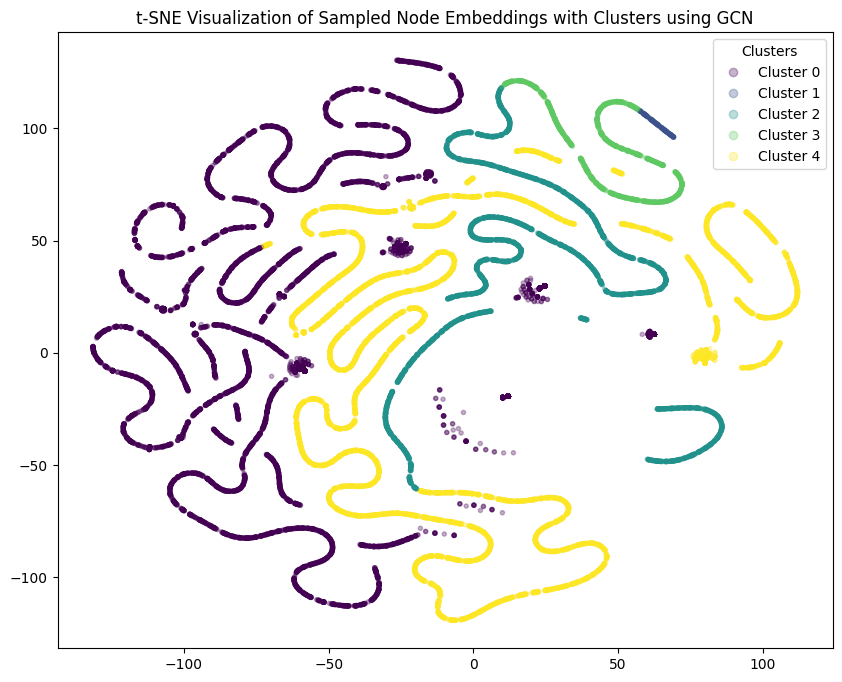

In [21]:
plot_community_2d(cluster_labels_gcn, node_embeddings_gcn, "GCN")

### Part 2 - Analyzing the Communities

##### Method 1 - DeepWalk

In [175]:
def calculate_modularity(graph, community_assignment):
    modularity = nx.algorithms.community.quality.modularity(graph, [set(community_assignment)])
    return modularity

def calculate_conductance(graph, community_assignment):
    conductance = nx.algorithms.community.quality.conductance(graph, community_assignment)
    return conductance

def calculate_coverage(ground_truth_communities, detected_communities):
    # Assuming both ground_truth_communities and detected_communities are lists of sets
    coverage = coverage_error(ground_truth_communities, detected_communities)
    return 1 - coverage

# Example usage:

# Assuming you have a NetworkX graph (graph) and community assignments (community_assignment)
# Make sure you have ground truth communities as well

# Example graph (replace this with your actual data)
edges = [(0, 1), (1, 2), (2, 0), (1, 3)]
graph = nx.Graph(edges)

# Example community assignment (replace this with your actual data)
community_assignment = {0: 0, 1: 1, 2: 0, 3: 1}

# Convert community assignment to a list of sets (required for coverage calculation)
detected_communities = [set(node for node, comm in community_assignment.items() if comm == c) for c in set(community_assignment.values())]

# Example ground truth communities (replace this with your actual data)
ground_truth_communities = [{0, 2}, {1, 3}]

# Calculate metrics
modularity = calculate_modularity(graph, community_assignment.values())
conductance = calculate_conductance(graph, detected_communities)
coverage = calculate_coverage(ground_truth_communities, detected_communities)

print(f"Modularity: {modularity}")
print(f"Conductance: {conductance}")
print(f"Coverage: {coverage}")


TypeError: 'int' object is not iterable

In [10]:
import networkx as nx


# Create a sample graph (replace this with your actual data)
G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (2, 4)])

# Modularity
communities = [{0, 1, 3}, {2, 4}]
modularity_value = modularity(G, communities)
print(f"Modularity: {modularity_value}")

# Conductance
cut_size = nx.cut_size(G, communities[0], communities[1])
volume = nx.volume(G, communities[0])
conductance_value = cut_size / volume
print(f"Conductance: {conductance_value}")

# Coverage
ground_truth_communities = [{0, 1, 3}, {2, 4}]  # Replace with actual ground truth communities
detected_communities = communities  # Replace with actual detected communities
coverage_value = 1 - coverage_error(ground_truth_communities, detected_communities)
print(f"Coverage: {coverage_value}")


Modularity: 0.08000000000000004
Conductance: 0.3333333333333333


ValueError: Expected 2D array, got 1D array instead:
array=[{0, 1, 3} {2, 4}].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Part 3 - Temporal Community Detection

## Task 3

### Link Prediction Algorithms
The following algorithms have been used for link prediction:  
- Node2Vec
- GraphSAGE

We have to implement one GNN method. Either GCN or GraphSAGE can be implemented.

However, if you have a graph with unevenly distributed node degrees and significant variability, GraphSAGE might be a more suitable choice for link prediction. It inherently samples neighborhoods during training, allowing it to handle nodes with different degrees more effectively.

### Comparing the Predictions